# 1. Setup

In [1]:
import os
import string 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'English'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'

In [3]:
cpu_count = 8 #os.cpu_count()
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

8
cuda


# 2. Define character class

In [4]:
lower_characters = list(string.ascii_lowercase)
upper_characters = list(string.ascii_uppercase)
numbers = [str(i) for i in range(10)]
characters = ['-'] + lower_characters + upper_characters + numbers
print(len(characters))
print(characters)

63
['-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [5]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'A', 28: 'B', 29: 'C', 30: 'D', 31: 'E', 32: 'F', 33: 'G', 34: 'H', 35: 'I', 36: 'J', 37: 'K', 38: 'L', 39: 'M', 40: 'N', 41: 'O', 42: 'P', 43: 'Q', 44: 'R', 45: 'S', 46: 'T', 47: 'U', 48: 'V', 49: 'W', 50: 'X', 51: 'Y', 52: 'Z', 53: '0', 54: '1', 55: '2', 56: '3', 57: '4', 58: '5', 59: '6', 60: '7', 61: '8', 62: '9'}
{'-': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, '

# 3. Define data loader

In [6]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [7]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

# 4. Define model

In [8]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [9]:
for p in resnet.parameters():
    p.requires_grad = False

In [10]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

# 5. Make predictions

In [11]:
batch_size = 64
rnn_hidden_size = 256

In [12]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir)

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

In [13]:
model_path = f'Models/{language}-Unicode-e30.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)
crnn.eval()

CRNN(
  (dp1): Dropout(p=0.5, inplace=False)
  (dp2): Dropout(p=0.5, inplace=False)
  (dp3): Dropout(p=0.5, inplace=False)
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [14]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [15]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [16]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)

In [17]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
train_result.head()

(500000, 3)
(5000, 3)
(5000, 3)


,image_fn,actual,prediction
0,Exertions_488_27205.jpg,Exertions,E-x-erti-on-s
1,Overaggressive_232_54297.jpg,Overaggressiv,oEEEEEeeeeeee
2,laughing_329_43561.jpg,laughing,l-a-u-gh-in-g
3,Deformation_205_20109.jpg,Deformation,Defoormatioon
4,Ritualism_59_66261.jpg,Ritualism,a---uaalis-m-


In [18]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [19]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)

In [20]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)

In [21]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [23]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)

# 6. Evaluate the model

In [28]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy)

0.797376 0.7634 0.7604


In [31]:
accuracy_df = []
for max_edit_distance in range(4+1):
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    accuracy_df.append([max_edit_distance, train_accuracy, val_accuracy, test_accuracy])
columns=['Max-Edit-Distance', 'Train-Accuracy', 'Val-Accuracy', 'Test-Accuracy']
accuracy_df = pd.DataFrame(accuracy_df, columns=columns)
accuracy_df.to_csv(f'Results/{language}.csv', index=False)
accuracy_df

,Max-Edit-Distance,Train-Accuracy,Val-Accuracy,Test-Accuracy
0,0,0.797376,0.7634,0.7604
1,1,0.879522,0.8522,0.8502
2,2,0.910600,0.8916,0.8858
3,3,0.927800,0.9070,0.9074
4,4,0.939812,0.9208,0.9210


In [32]:
test_result['edit_distance'].describe()

count    5000.000000
mean        0.901600
std         2.253116
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        13.000000
Name: edit_distance, dtype: float64

In [33]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=1):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
    elif split == "Test-V2":
        result = test_result_v2
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        if split == 'Test-V2':
            image_fp = f'Data/{language}-V2-Test/{row["image_fn"]}'
        else:
            image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

In [34]:
#visualize_misclassifications('Train')

In [35]:
#visualize_misclassifications('Val')

('Actual:', 'Flamed', 'Prediction:', 'f-i-a-m--e-d-', 'Prediction Corrected:', 'fiamed')


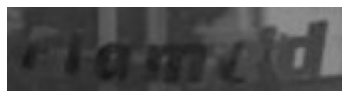

('Actual:', 'PREHISTORICAL', 'Prediction:', 'P-PEH-ETORO-S', 'Prediction Corrected:', 'PPEHETOROS')


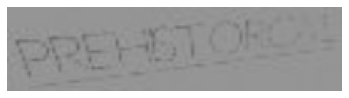

('Actual:', 'Sunroof', 'Prediction:', 's--a--d-o-of-', 'Prediction Corrected:', 'sadoof')


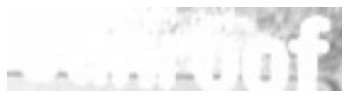

('Actual:', 'Sejong', 'Prediction:', 'S---O-o-N--G-', 'Prediction Corrected:', 'SOoNG')


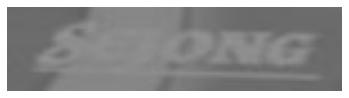

('Actual:', 'Luscious', 'Prediction:', 'L--u-sdio-u-s', 'Prediction Corrected:', 'Lusdious')


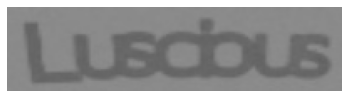

('Actual:', 'Unembarrassed', 'Prediction:', 'UmmmmEeeeeeee', 'Prediction Corrected:', 'UmEe')


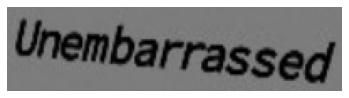

('Actual:', 'Glitterati', 'Prediction:', 'G-it-teera-ti', 'Prediction Corrected:', 'Gitterati')


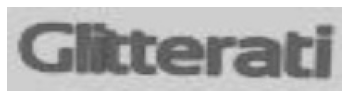

('Actual:', 'Liniment', 'Prediction:', 'L-in-im-a-n-t', 'Prediction Corrected:', 'Linimant')


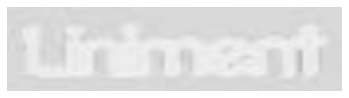

('Actual:', 'OUTLANDISHLY', 'Prediction:', 'OUTTANOISHILY', 'Prediction Corrected:', 'OUTANOISHILY')


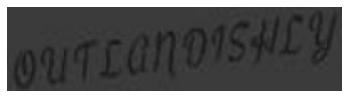

('Actual:', 'cliches', 'Prediction:', 'H--a-a--e----', 'Prediction Corrected:', 'Haae')


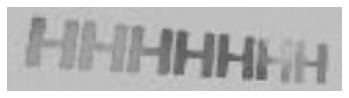

('Actual:', 'oscillations', 'Prediction:', 'oscil-latioms', 'Prediction Corrected:', 'oscillatioms')


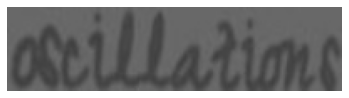

('Actual:', 'LEGATIONS', 'Prediction:', 'L-E-CATION-S-', 'Prediction Corrected:', 'LECATIONS')


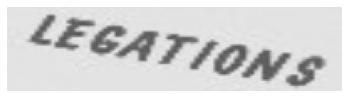

('Actual:', 'Undercurrents', 'Prediction:', 'UNRRRUUNNENNS', 'Prediction Corrected:', 'UNRUNENS')


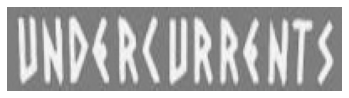

('Actual:', 'EPIGRAM', 'Prediction:', 'E--P-IG-AA-M-', 'Prediction Corrected:', 'EPIGAM')


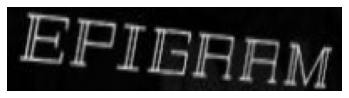

('Actual:', 'ANTHOLOGIZES', 'Prediction:', 'MN-POOOOIZEES', 'Prediction Corrected:', 'MNPOIZES')


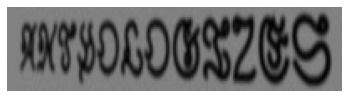

('Actual:', 'INCONCLUSIVEL', 'Prediction:', 'INCONCULSSEEL', 'Prediction Corrected:', 'INCONCULSEL')


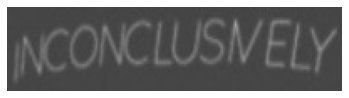

('Actual:', 'PUBLICAN', 'Prediction:', 'P-U-P-LICA-N-', 'Prediction Corrected:', 'PUPLICAN')


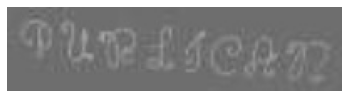

('Actual:', 'MISADDRESSING', 'Prediction:', 'mIEEIEEESSNNN', 'Prediction Corrected:', 'mIEIESN')


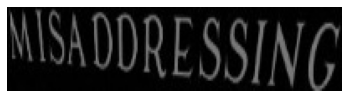

('Actual:', 'MANUMISSIONS', 'Prediction:', 'MmNNNmmN-NNNS', 'Prediction Corrected:', 'MmNmNNS')


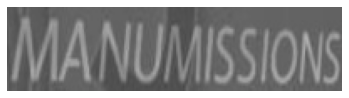

('Actual:', 'hormonal', 'Prediction:', 'H-O-R-MO-N-AL', 'Prediction Corrected:', 'HORMONAL')


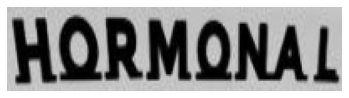

In [36]:
visualize_misclassifications('Test')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [ ]:
#test_result